In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Modules

### agent
This is a module I wrote as a way of reducing redundant code, which also helped making experiments with these agents easier, check the end of the notebook for code. or check [repo](https://github.com/arjunbazinga/MultiArmedBandits).

### arms
This implements basic arm which samples from a normal distribution with some fixed mean and deviation, which is randomly initialised.


In [2]:
import agent
import arms

In [27]:
def avg(l):
    #gives back the average; used to find average reward
    return sum(l)/len(l)

def maxreward(arms):
    #Max rewards
    a= [arm.mu for arm in arms]
    return max(a)

def avgreward(rewards):
    ans = []
    ans.append(rewards[0])
    for i in range(1,len(rewards)):
        ans.append(ans[i-1]+rewards[i])
    for i in range(len(ans)):
        ans[i]/=i+1
    return ans

def cosine_similarity(a,b):
    temp = a*b
    temp/=(euclid_distance(a)* euclid_distance(b))
    return np.sum(temp, axis=0)
    
def euclid_distance(a):
    return np.sqrt(np.sum(a*a, axis=0))

In [55]:
def test(agents, iterations):
    for agent in agents:
        print(agent)
        agent.gamble(iterations)
        temp = [ arm.mu for arm in levers] 
        optimal = np.zeros_like(agent.expectations)
        optimal[temp.index(max(temp))] = 1
        
        
        
        print("maximum possible reward:", maxreward(levers))
        print("average reward:", avg(agent.reward_history))
        
        plt.plot(avgreward(agent.reward_history))
        plt.ylabel('Average Reward')
        plt.xlabel('Iteration')
        plt.show()
    
        
        
        print("cosine simmmilarity" ,cosine_similarity(agent.policy(), optimal))
        print("euclidian distance ",euclid_distance(agent.policy()-optimal)/len(optimal))
        print("\n")
        
        # print("optimal policy:" , optimal)
        # print("learnt policy:" ,agent.policy())
        
    
        
        # plt.scatter(range(len(agent.choice_history)),y=agent.choice_history)
        # plt.title("Choices")
        # plt.xlabel("time")
        # plt.ylabel("arm")
        # plt.show()
        # print("\n")
    
    

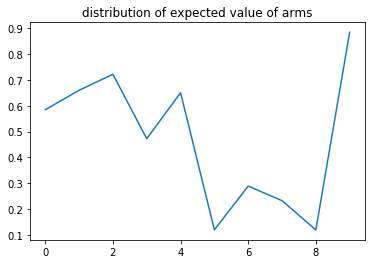

In [59]:
levers = arms.get_arms(10)

agents = [
    agent.epsilon_greedy(levers, epsilon=1),
    agent.epsilon_greedy(levers, epsilon=0),
    agent.softmax(levers, beta=0.1),
    agent.ucb(levers)

]
plt.plot([ arm.mu for arm in levers] )
plt.title("distribution of expected value of arms")

maximum possible reward: 0.876691089295
average reward: [ 0.45785394]


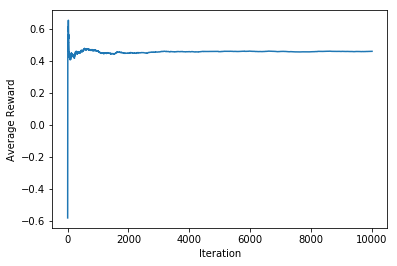

cosine simmmilarity 0.316227766017
euclidian distance  0.0948683298051


maximum possible reward: 0.876691089295
average reward: [ 0.86668801]


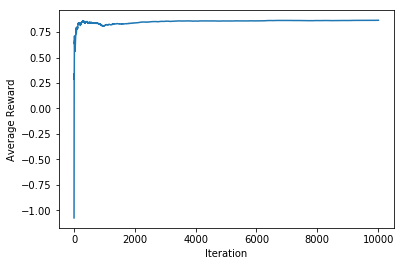

cosine simmmilarity 1.0
euclidian distance  0.0


maximum possible reward: 0.876691089295
average reward: [ 0.82350785]


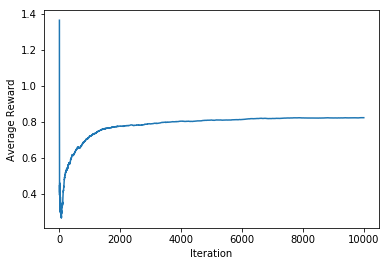

cosine simmmilarity 0.999406869917
euclidian distance  0.00756982505062


maximum possible reward: 0.876691089295
average reward: [ 0.84173303]


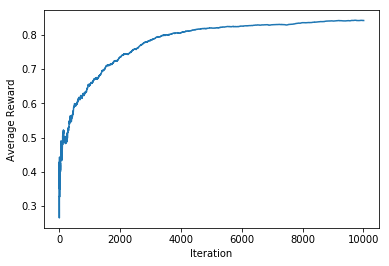

cosine simmmilarity 1.0
euclidian distance  0.0




In [57]:
test(agents, 10000)

## Appendix
Below is the code for agent and arms modules. This is in no way complete. See issues or todo for future plans.

In [ ]:
# %load agent
import numpy as np


class agent:
    def __init__(self, arms, play_once=1):
        self.expectations = np.zeros(len(arms))
        self.times_played = np.zeros(len(arms))
        self.arms = arms

        self.number_of_arms = len(arms)
        self.N = 0

        self.reward_history = []
        self.choice_history = []

        if play_once == 1:
            for i in range(self.number_of_arms):
                self.expectations[i] = self.play(i)

    def play(self, index):
        reward = self.arms[index].pull()

        self.times_played[index] += 1
        self.N += 1

        self.choice_history.append(index)
        self.reward_history.append(reward)

        return reward

    def policy(self):
        pass

    def update_expectations(self, reward, index):
        self.expectations[index] += (reward - self.expectations[index])/self.N

    def select_arm(self):
        options = range(self.number_of_arms)
        i = np.random.choice(options, p=self.policy(), replace=False)
        return i

    def gamble(self, iterations):
        for i in range(iterations):
            index = self.select_arm()
            reward = self.play(index)
            self.update_expectations(reward, index)


class ucb(agent):

    def __init__(self, arms, play_once=1):
        super().__init__(arms, play_once)

    def policy(self):
        temp = self.expectations + np.sqrt(2*np.log(self.N)/self.times_played)
        ans = np.zeros_like(temp)
        ans[np.argmax(temp)] = 1
        return ans


class softmax(agent):

    def __init__(self, arms, play_once=1, beta=1):
        super().__init__(arms, play_once)
        self.beta = beta

    def policy(self):
        temp = np.exp(self.expectations/self.beta)
        ans = temp / np.sum(temp, axis=0)
        return ans


class epsilon_greedy(agent):

    def __init__(self, arms, play_once=1, epsilon=0.1):
        super().__init__(arms, play_once)
        self.epsilon = epsilon

    def policy(self):
        temp = np.zeros_like(self.expectations)
        temp[np.argmax(self.expectations)] = 1-self.epsilon
        ans = temp + self.epsilon/self.number_of_arms
        return ans


class softmax_with_exponentiation(agent):

    def __init__(self, arms, play_once=1, beta=1, exp=1):
        super().__init__(arms, play_once)
        self.beta = beta
        self.exp = exp

    def policy(self):
        temp = np.exp(self.expectations/self.beta)
        ans = temp / np.sum(temp, axis=0)
        ans = ans**self.exp
        ans /= np.sum(ans, axis=0)
        return ans


class softmax_with_reccurence(agent):

    def __init__(self, arms, play_once=1, beta=1):
        super().__init__(arms, play_once)
        self.old_policy = np.ones_like(self.expectations)/self.l
        self.beta = beta

    def policy(self):
        temp = np.exp(self.expectations/self.beta)
        new_policy = temp / np.sum(temp, axis=0)

        result = np.multiply(new_policy, self.old_policy)
        result /= np.sum(result, axis=0)
        self.old_policy = result

        return result


class greedy_with_reccurence(agent):
    # alpha = number < 1; will sum over a number of observations and will keep
    # osiclating.
    # alpha = N will allow the algo to converge to an arm, greedy doesn't
    # really need this, kind of always give one answer.

    def __init__(self, arms, play_once=1, alpha=1):
        super().__init__(arms, play_once)
        self.old_policy = np.ones_like(self.expectations)
        self.alpha = alpha

    def policy(self):
        new_policy = np.zeros_like(self.expectations)
        new_policy[np.argmax(self.expectations)] = 1

        new_policy = (1-self.alpha)*new_policy + self.alpha*self.old_policy

        new_policy /= np.sum(new_policy, axis=0)
        self.old_policy = new_policy

        return new_policy

# class magic(agent):
#    def __init__(self, arms, play_once=1, exp=1):
#        super().__init__(arms, play_once)
#        self.old_policy = np.ones_like(self.expectations)/self.l
#        self.exp = exp
#
#    def policy(self):
#        new_policy = f(old_policy, g(expectations))
